# Futures Trading Considerations

We will consider some practical implications for trading futures contracts. We will discuss the futures calendar and how it impacts trading as well as how to maintain futures positions across expiries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Futures Calendar
An important feature of futures markets is the calendar used to trade them. Futures markets are open long after the equity markets close, though the effective periods within which you can trade with large amounts of liquidity tend to overlap. The specific high points in volume for futures contracts vary greatly from underlying to underlying. Despite this, the  majority of the volume for many contracts typically falls within normal EST market hours.

Let's have a look at a day in the life of the S&P 500 Index E-Mini futures contract that was deliverable in March 2017.

In [2]:
contract = symbols('ESH17')
one_day_volume = get_pricing(contract, start_date='2017-02-01', end_date='2017-02-01', frequency='minute', fields='volume')

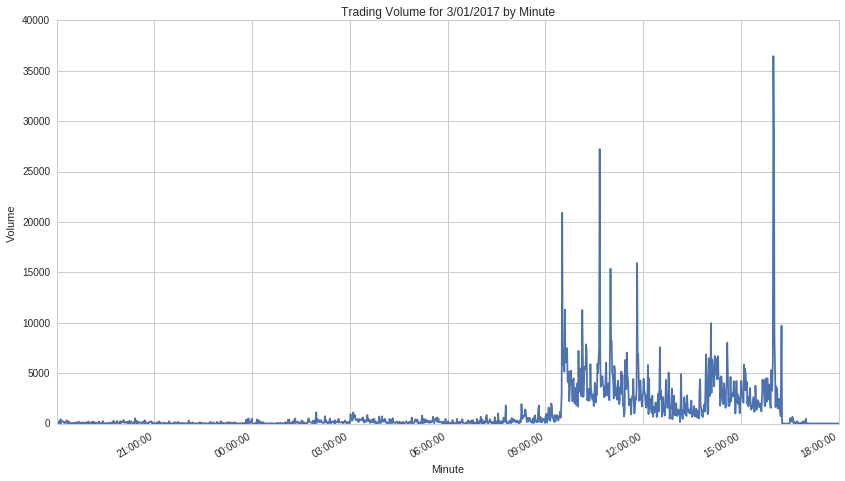

In [3]:
one_day_volume.tz_convert('EST').plot()
plt.title('Trading Volume for 3/01/2017 by Minute')
plt.xlabel('Minute')
plt.ylabel('Volume');

This is one of the most liquid futures contracts and we see this significant increase in volume traded during normal equity trading hours. These hours can be even more tight for less liquid commodities. For example, let's look at how Feeder Cattle trades during the same time period on the same day.

In [4]:
contract = 'FCH17'
one_day_volume = get_pricing(contract, start_date='2017-02-01', end_date='2017-02-01', frequency='minute', fields='volume')

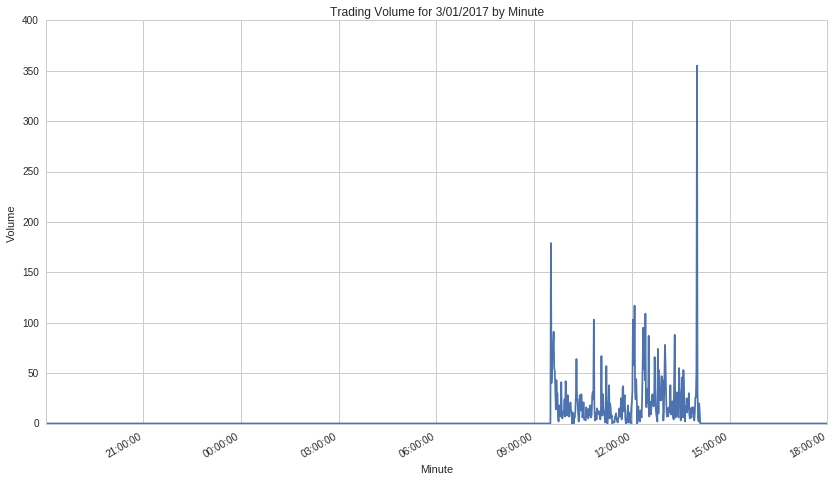

In [5]:
one_day_volume.tz_convert('EST').plot()
plt.title('Trading Volume for 3/01/2017 by Minute')
plt.xlabel('Minute')
plt.ylabel('Volume');

If we are trying to trade multiple different underlyings with futures contracts in the same algorithm, we need to be conscious of their volume relative to each other. All trading algorithms are dependent on orders being executed as determined by their calculations. Some contracts are so illiquid that entering into even the smallest position will amount to becoming a large part of the volume for a given day. This could heavily impact slippage

Unsurprisingly, volume will also vary for different expiries on the same underlying. The front month contract, the contract closest to delivery, has the largest amount of volume. As we draw closer to delivery the front month's volume is eclipsed by the next expiry date as participants in the market close out their positions and roll them forward.

In [6]:
contracts = symbols(['ESH16', 'ESM16', 'ESU16'])
rolling_volume = get_pricing(contracts, start_date='2015-12-15', end_date='2016-09-15', fields='volume')

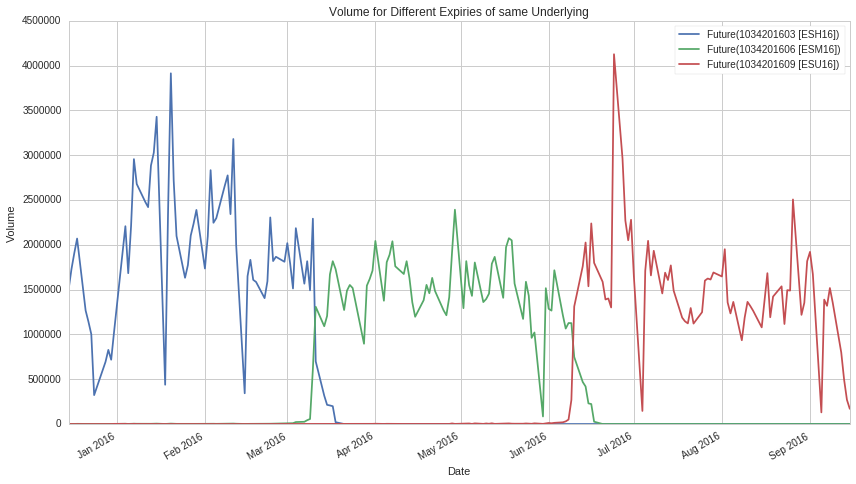

In [7]:
rolling_volume.plot()
plt.title('Volume for Different Expiries of same Underlying')
plt.xlabel('Date')
plt.ylabel('Volume');

## Futures Positions Have Inherent Leverage
In entering a futures position, you place down a certain amount of capital in a margin account. This margin account is exposed to the fluctuating futures price of the underlying that you have chosen. This creates a levered position off the bat as the value that you are exposed to (before delivery) in the account is different from the overall value that is on the hook at delivery.

This internal leverage is determined on a contract to contract basis due to the different multipliers involved for different underlyings.

## Roll-over
If we want to maintain a futures position across expiries, we need to "roll over" our contracts. This is the practice of switching to the next month's contract after closing your previous holding. The majority of futures positions are either closed or rolled over before ever reaching delivery.

The futures contract with expiry closest to the current date is known as the "front month" contract. It usually enjoys the smallest spread between futures and spot prices as well as the most liquidity. In contrast, the futures contract that has the furthest expiration date in a set of contracts is known as the "back month" contract. Contracts that are further out have significantly less liquidity, though they still may contain vague information about future prices anticipated by the market.

By rolling forward our positions, we can maintain a hedge on a particular underlying or simply maintain a position across time. Without rolling contracts over we would be required to develop trading strategies that work only on a short timescale.

This graph illustrates the volume that results from rolling over contracts on the first date where the front month contract's volume is eclipsed by the following month on the same underlying.

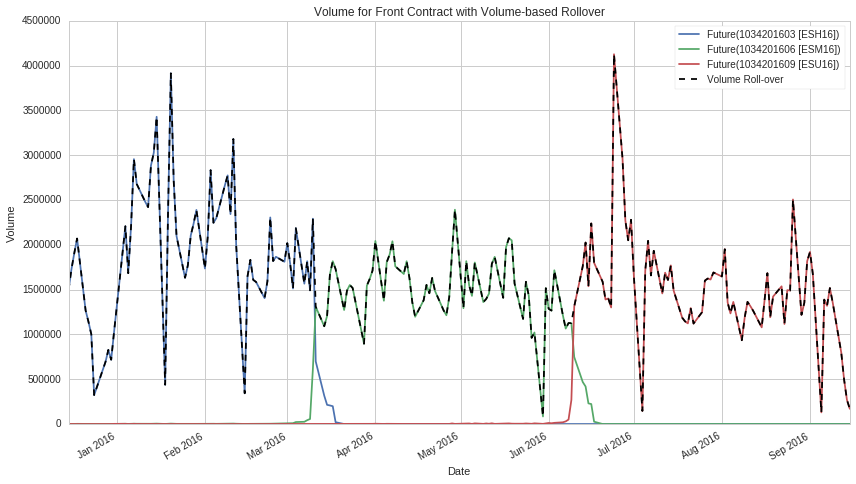

In [8]:
maximum_any_day_volume = rolling_volume.max(axis=1)
maximum_any_day_volume.name = 'Volume Roll-over'
rolling_volume.plot()
maximum_any_day_volume.plot(color='black', linestyle='--')
plt.title('Volume for Front Contract with Volume-based Rollover')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend();

In this particular instance, our goal is to ride the wave of liquidity provided by the front contract. 

## Continuous Futures
With futures, it is difficult to get a continuous series of historical prices. Each time that you roll forward to a new contract, the price series incurs a jump. This jump negatively impacts our analysis of prices as the discontinuity introduces shocks in our return and volatility measures that may not be representative of the actual changes in the underlying.

We use the continuous futures objects as part of the platform to get a continuous chain of historical data for futures contracts, taking these concerns into account. There are several ways to adjust for the cost of carry when looking at historical data, though people differ on what they prefer. The general consensus is that an adjustment should be done.

We can have a continuous future "roll" forward either based on calendar dates or based on the shift in volume from the front month contract to the next. The `ContinuousFuture` object is not a tradable asset, however. It is an API construct that abstracts the chain of consecutive contracts for the same underlying. They maintain ongoing references to the active contract in the chain and make it easier to to maintain a dynamic reference to contracts that you want to order as well as to get historical series of data, all based on your chosen method of adjustment and your desired roll method.

In [9]:
continuous_corn = continuous_future('CN', offset=0, roll='calendar', adjustment='mul')

The above defined continuous future has an `offset` of $0$, indicating that we want it to reference the front month contract at each roll. Incrementing the offset causes the continuous future to instead monitor the contract that is displaced from the front month by that number.

### Adjustments
We can define a continuous future to use multiplicative adjustments, additive adjustments, or no adjustments (`'mul'`, `'add'`, `None`). The cost of carry that is realized as we shift from one contract to the next can be seen as the shock from a dividend payment. Adjustments are important to frame past prices relative to today's prices by including the cost of carry. Additive adjustments close the gaps betwen contracts by simply taking the differences and aggregating those back, while multiplicative adjustments scale previous prices using a ratio to close the gap.

In [10]:
continuous_corn_price = history(continuous_corn, start_date='2009-01-01', end_date='2016-01-01', fields='price')

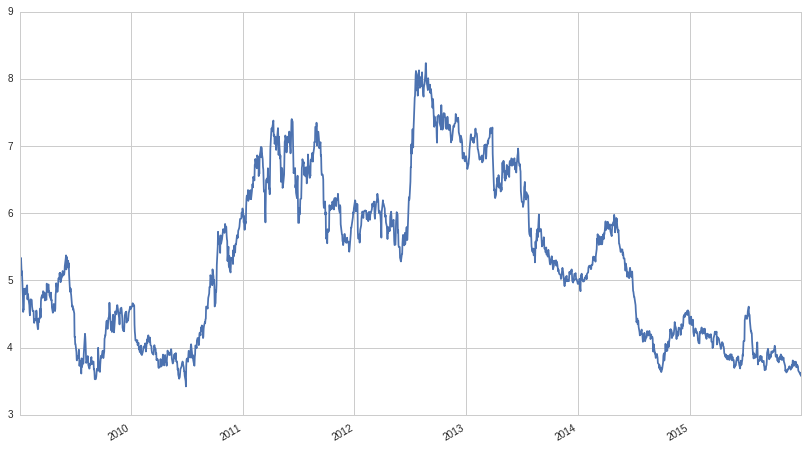

In [11]:
continuous_corn_price.plot();

Once we have a continuous time series of prices we can conduct meaningful statistical analysis to form a foundation for our research. 

## Fewer Assets
There are around 8000 equities in the US market, but there are far fewer futures contracts, especially those with enough liquidity to trade. We can make up for this by trading different expiries on the same underlying, though we need to ensure that we are conducting rigorous testing to ensure that our resulting signals are viable in the market given the potential liquidity constraints that come with not trading the front month.